# Plot results of barcode depletion screens

## Load libraries

In [1]:
options(warn = -1)
suppressPackageStartupMessages({
  library(tidyverse)
  library(rasilabRtemplates)
})

cbPalette_12 <- c(
  "#88CCEE", "#CC6677", "#117733", "#999933", "#332288", "#AA4499",
  "#661100", "#44AA99", "#882255", "#6699CC", "#DDCC77", "#888888"
)

theme_set(theme_rasilab() + 
  theme(
    axis.line = element_line(color = "grey"), 
    axis.title.y = element_text(margin = margin(r=10)),
    axis.title.x = element_text(margin = margin(t=10))
  )
)

umi_cutoff <- 20
umi_grna_cutoff <- 1

## Read sample annotations

In [2]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", show_col_types = F) %>%
  print()

# A tibble: 40 × 25
   sample_…¹ srr   owner sampl…² libra…³ plasm…⁴ ampli…⁵ illum…⁶ sampl…⁷ barco…⁸
       <dbl> <chr> <chr> <chr>   <chr>   <chr>   <chr>   <chr>   <chr>     <dbl>
 1        93 SRR2… pn    ntc_da… grna    pAS244  lPNHS21 pn_219… 219p138       1
 2        94 SRR2… pn    ntc_da… grna    pAS244  lPNHS21 pn_219… 219p139       1
 3        95 SRR2… pn    ntc_da… grna    pAS244  lPNHS21 pn_219… 219p140       1
 4        96 SRR2… pn    ntc_da… grna    pAS244  lPNHS21 pn_219… 219p141       1
 5        76 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p27        1
 6        77 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p29        1
 7        78 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p31        1
 8        63 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p3         1
 9        79 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p33        1
10        80 SRR2… pn    ntc_da… mrna    pAS244  lPNHS23 pn_219… 219p34        1
# … with

## Read barcode counts for day 1 gDNA and mRNA

In [3]:
barcode_counts <- c("../data/subpool_barcode_counts/219p138.csv","../data/subpool_barcode_counts/219p27.csv") %>%
  as_tibble_col("file") %>%
  mutate(sample_id = str_extract(file, "219p\\d+")) %>%
  inner_join(sample_annotations %>% select(sample_name, sample_id), by = "sample_id") %>%
  mutate(data = map(file, ~read_csv(.x, show_col_types = F))) %>%
  select(-file) %>%
  unnest() %>%
  print()

# A tibble: 206,457 × 7
   sample_id sample_name       insert_num barcode_num umi_count read_c…¹ barco…²
   <chr>     <chr>                  <dbl>       <dbl>     <dbl>    <dbl> <chr>  
 1 219p138   ntc_day1_bc1_grna          0      310977        12      234 A      
 2 219p138   ntc_day1_bc1_grna          0      326782        12      190 B      
 3 219p138   ntc_day1_bc1_grna          0     1138434        12      181 B      
 4 219p138   ntc_day1_bc1_grna          0     1333102        12      321 B      
 5 219p138   ntc_day1_bc1_grna          0       90190         8      147 B      
 6 219p138   ntc_day1_bc1_grna          0      296000         7       63 B      
 7 219p138   ntc_day1_bc1_grna          0     2011828         6       32 B      
 8 219p138   ntc_day1_bc1_grna          0      361005         5      154 A      
 9 219p138   ntc_day1_bc1_grna          0      202158         4       81 B      
10 219p138   ntc_day1_bc1_grna          0     1080120         3       25 B      
# … 

## CDF of barcode counts on day 1 for gDNA and cDNA

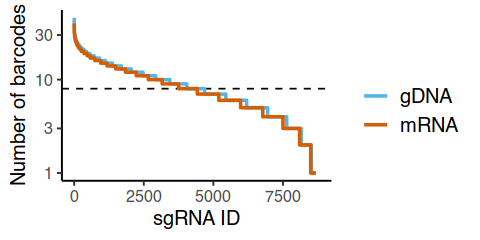

In [4]:
options(repr.plot.width = 4, repr.plot.height = 2)

plot_data <- barcode_counts %>%
  mutate(cutoff = if_else(str_detect(sample_name, "grna"), read_count >= umi_grna_cutoff, umi_count >= umi_cutoff)) %>%
  filter(cutoff) %>%
  group_by(sample_name, insert_num) %>%
  summarize(n_barcodes = n(), .groups = "drop") %>%
  group_by(sample_name) %>%
  arrange(desc(n_barcodes)) %>%
  mutate(x = 1:n()) %>%
  ungroup() %>%
  filter(n_barcodes < 100) %>%
  mutate(type = if_else(str_detect(sample_name, "total"), "mRNA", "gDNA"))

median_data <- plot_data %>%
  group_by(sample_name) %>%
  summarize(n_barcodes = median(n_barcodes), .groups = "drop") %>%
  write_csv("../../../../source_data/figure_s1e.csv")

plot_data %>%
  ggplot(aes(x = x, y = n_barcodes, color = type, group = type)) +
  geom_hline(aes(yintercept = n_barcodes), linetype = "dashed", data = median_data) + 
  geom_line(linewidth = 1) +
  scale_y_log10() +
  scale_x_continuous(limits = c(0, 8800)) +
  scale_color_manual(values = cbPalette[c(3,7)]) +
  theme_rasilab() +
  labs(x = "sgRNA ID", y = "Number of barcodes", color = "")

ggsave("../figures/cdf_sgrna_n_barcodes.pdf", width = 4, height = 2)

## PDF of read counts for sgRNA

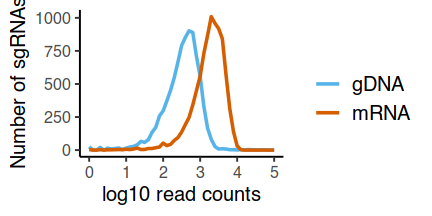

In [5]:
options(repr.plot.width = 3.6, repr.plot.height = 1.8)

plot_data <- barcode_counts %>%
  mutate(umi_count = if_else(str_detect(sample_name, "grna"), read_count, umi_count)) %>%
  group_by(sample_name, insert_num) %>%
  summarize(umi_count = sum(umi_count), .groups = "drop") %>%
  mutate(type = if_else(str_detect(sample_name, "total"), "mRNA", "gDNA")) %>%
  write_csv("../../../../source_data/figure_s1d.csv")

plot_data %>% 
  ggplot(aes(x = log10(umi_count), color = type)) +
  geom_freqpoly(binwidth=0.1, linewidth = 1) +
  scale_color_manual(values = rasilabRtemplates::cbPalette[c(3,7)]) +
  theme_rasilab() +
  labs(x = "log10 read counts", y = "Number of sgRNAs", color = "") +
  scale_x_continuous(limits = c(0, 5))

ggsave("../figures/pdf_sgrna_umi_counts.pdf", width = 3.6, height = 2)

## Load MaGeCK gene hit data

In [6]:
mageck_gene <- list.files("../data/mageck/", full.names = T, recursive = T, pattern = "gene_summary.tsv$") %>%
  as_tibble_col("file") %>%
  filter(str_detect(file, "ntc.+bc1.+(total|grna).+ntc.+bc1.+(total|grna)"), !str_detect(file, "total.+grna")) %>%
  mutate(sample_name = str_extract(file, "(?<=mageck//).+(?=/mageck.)")) %>%
  separate(sample_name, c("treatment", "control"), sep = "_vs_", remove = F) %>%
  mutate(data = map(file, . %>% read_tsv(show_col_types = F))) %>%
  select(-file) %>%
  unnest(data) %>%
  janitor::clean_names() %>%
  select(-pos_lfc) %>%
  rename(lfc = neg_lfc, gene = id) %>%
  mutate(lfc = round(lfc, 2)) %>%
  arrange(neg_rank)

mageck_gene

sample_name,treatment,control,gene,num,neg_score,neg_p_value,neg_fdr,neg_rank,neg_goodsgrna,lfc,pos_score,pos_p_value,pos_fdr,pos_rank,pos_goodsgrna
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ntc_day13_bc1_grna_vs_ntc_day1_bc1_grna,ntc_day13_bc1_grna,ntc_day1_bc1_grna,RPS24,4,1.3766e-06,6.7939e-06,0.002769,1,4,-5.05,1,1,NA,2186,0
ntc_day13_bc1_total_vs_ntc_day1_bc1_total,ntc_day13_bc1_total,ntc_day1_bc1_total,PRPF19,4,3.1612e-08,2.2646e-06,0.001748,1,4,-7.52,1,1,NA,2186,0
ntc_day21_bc1_grna_vs_ntc_day1_bc1_grna,ntc_day21_bc1_grna,ntc_day1_bc1_grna,RPS24,4,1.4135e-06,6.7939e-06,0.005272,1,4,-4.33,1,1,NA,2186,0
ntc_day21_bc1_total_vs_ntc_day1_bc1_total,ntc_day21_bc1_total,ntc_day1_bc1_total,RPS24,4,6.3481e-07,2.2646e-06,0.002063,1,4,-6.98,1,1,NA,2186,0
ntc_day3_bc1_total_vs_ntc_day1_bc1_total,ntc_day3_bc1_total,ntc_day1_bc1_total,POLR2F,4,2.5259e-09,2.2646e-06,0.000412,1,4,-0.83,1,1,NA,2186,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ntc_day21_bc1_total_vs_ntc_day1_bc1_total,ntc_day21_bc1_total,ntc_day1_bc1_total,DAZ3,4,0.99992,0.99994,NA,2186,0,2.66,7.5153e-05,2.6043e-04,0.007551,3,4
ntc_day3_bc1_total_vs_ntc_day1_bc1_total,ntc_day3_bc1_total,ntc_day1_bc1_total,RAX,4,0.99982,0.99983,NA,2186,0,0.48,1.8049e-04,7.0883e-04,0.081752,3,4
ntc_day5_bc1_grna_vs_ntc_day1_bc1_grna,ntc_day5_bc1_grna,ntc_day1_bc1_grna,UBE2O,4,0.99985,0.99986,NA,2186,0,1.15,1.4163e-01,1.4035e-01,NA,313,0


In [7]:
mageck_gene %>%
  mutate(day = str_extract(treatment, "day\\d+"), type = str_extract(control, "total|grna")) %>%
  filter(day %in% c("day5", "day13", 'day21'), str_detect(sample_name, "total.+total|total.+grna")) %>%
  distinct(sample_name)

sample_name
<chr>
ntc_day13_bc1_total_vs_ntc_day1_bc1_total
ntc_day21_bc1_total_vs_ntc_day1_bc1_total
ntc_day5_bc1_total_vs_ntc_day1_bc1_total


## Read essential gene list

In [8]:
essential_genes <- read_csv("../annotations/DepMapCRISPRInferredCommonEssentials_23Q2.csv", show_col_types = F) %>% 
  separate(Essentials, c("gene", "num")) %>% 
  select(gene) %>%
  mutate(essential = TRUE) %>%
  print()

# A tibble: 1,687 × 2
   gene  essential
   <chr> <lgl>    
 1 AAMP  TRUE     
 2 AARS1 TRUE     
 3 AATF  TRUE     
 4 ABCB7 TRUE     
 5 ABCE1 TRUE     
 6 ABCF1 TRUE     
 7 ABT1  TRUE     
 8 ACIN1 TRUE     
 9 ACLY  TRUE     
10 ACO2  TRUE     
# … with 1,677 more rows


## Plot mRNA fold-change vs. gDNA fold-change after Cas9 induction

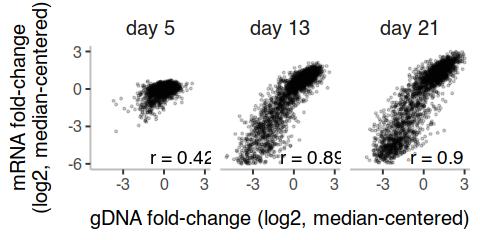

In [9]:
options(repr.plot.width= 4, repr.plot.height = 2)

plot_data = mageck_gene %>% 
  mutate(day = str_extract(treatment, "day\\d+"), type = str_extract(treatment, "total|grna")) %>%
  filter(day %in% c("day5", "day13", 'day21'), str_detect(sample_name, "total.+total|grna.+grna")) %>%
  mutate(type = if_else(type == "total", "mRNA", "gDNA")) %>%
  select(gene, day, type, lfc) %>% 
  pivot_wider(names_from = type, values_from = lfc) %>%
  mutate(daynum = as.integer(str_replace(day, "day", ""))) %>%
  mutate(day = fct_reorder(paste0("day ", daynum), daynum)) %>%
  select(-daynum) %>%
  arrange(gene, day) %>%
  write_csv("../../../../source_data/figure_1d.csv")

correlation <- plot_data %>% 
  group_by(day) %>% 
  nest() %>%
  mutate(cor = map(data, ~cor.test(~ mRNA + gDNA, data=.x, method = "spearman", exact = F))) %>%
  mutate(cor = map(cor, broom::tidy)) %>%
  select(-data) %>%
  unnest(cor)

plot_data %>%
  ggplot(aes(x = gDNA, y = mRNA)) +
  facet_wrap(~day) + 
  geom_point(size = 0.5, alpha = 0.2) +
  geom_text(data = correlation, aes(label = paste0("r = ", round(estimate, 2))), x = -1, y = -6, hjust = 0, vjust = 0, size = 4) +
  scale_x_continuous(breaks = c(-6, -3, 0, 3), limits = c(-5, 3)) +
  scale_y_continuous(breaks = c(-6, -3, 0, 3), limits = c(-6, 3)) +
  labs(
    x = "gDNA fold-change (log2, median-centered)",
    y = "mRNA fold-change\n(log2, median-centered)")

ggsave("../figures/compare_mrna_gdna_foldchange_with_time.pdf", width = 4, height = 2)

## NTC mRNA fold change with time

Picking joint bandwidth of 0.237

Picking joint bandwidth of 0.237

Picking joint bandwidth of 0.237



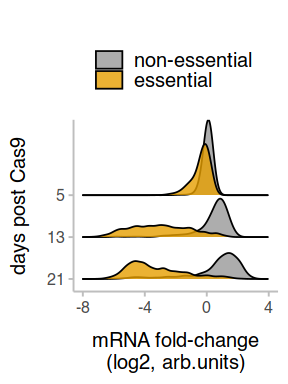

In [10]:
options(repr.plot.width= 2.4, repr.plot.height = 3.2)

plot_data = mageck_gene %>% 
  filter(str_detect(treatment, "total"), control == "ntc_day1_bc1_total") %>%
  mutate(day = str_extract(treatment, "(?<=day)\\d+")) %>%
  filter(day %in% c("5", "13", "21")) %>%
  select(gene, day, lfc) %>%
  left_join(essential_genes, by = "gene") %>%
  group_by(day, essential) %>% 
  mutate(n = n()) %>%
  ungroup() %>%
  mutate(essential = if_else(is.na(essential), "non-essential", "essential")) %>%
  mutate(day = fct_reorder(day, -as.integer(day))) %>%
  arrange(gene, day, essential) %>%
  write_csv("../../../../source_data/figure_1e_mrna.csv")

plot_data %>%
  ggplot(aes(x = lfc, y = day, fill = fct_rev(essential))) +
  ggridges::geom_density_ridges(alpha = 0.8) +
  labs(x = "mRNA fold-change\n(log2, arb.units)", y = "days post Cas9", fill = "") +
  theme(axis.line = element_line(color = "grey"),
        axis.ticks = element_line(color = "grey"), 
        legend.position = "top", legend.direction = "vertical", legend.key.height = unit(0.2, "cm")) +
  scale_y_discrete(expand = c(0.1, 0.1)) +
  scale_x_continuous(limits = c(-8,4), breaks = c(-8, -4, 0, 4))

ggsave("../figures/ntc_total_mrna_foldchange_with_time.pdf", width = 2.4, height = 3.2, units = "in")

In [11]:
plot_data %>%
  group_by(essential, day) %>%
  summarize(n = n(), median_lfc = median(lfc), .groups = "drop") %>%
  group_by(day) %>%
  mutate(lfc_ctrl = median_lfc - median_lfc[essential == "non-essential"]) %>%
  ungroup()

essential,day,n,median_lfc,lfc_ctrl
<chr>,<fct>,<int>,<dbl>,<dbl>
essential,21,785,-3.72,-4.84
essential,13,785,-3.07,-3.77
essential,5,785,-0.21,-0.30
non-essential,21,1401,1.12,0.00
non-essential,13,1401,0.70,0.00
non-essential,5,1401,0.09,0.00


## NTC genomic DNA fold change with time

Picking joint bandwidth of 0.203

Picking joint bandwidth of 0.203

Picking joint bandwidth of 0.203



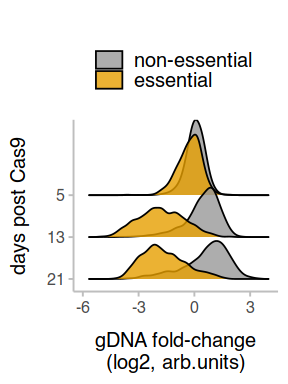

In [12]:
options(repr.plot.width= 2.4, repr.plot.height = 3.2)

plot_data = mageck_gene %>% 
  filter(str_detect(treatment, "grna"), control == "ntc_day1_bc1_grna") %>%
  mutate(day = str_extract(treatment, "(?<=day)\\d+")) %>%
  filter(day %in% c("5", "13", "21")) %>%
  select(gene, day, lfc) %>%
  left_join(essential_genes, by = "gene") %>%
  group_by(day, essential) %>% 
  mutate(n = n()) %>%
  ungroup() %>%
  mutate(essential = if_else(is.na(essential), "non-essential", "essential")) %>%
  mutate(day = fct_reorder(day, -as.integer(day))) %>%
  arrange(gene, day, essential) %>%
  write_csv("../../../../source_data/figure_1e_gdna.csv")

plot_data %>%
  ggplot(aes(x = lfc, y = day, fill = fct_rev(essential))) +
  ggridges::geom_density_ridges(alpha = 0.8) +
  labs(x = "gDNA fold-change\n(log2, arb.units)", y = "days post Cas9", fill = "") +
  theme(axis.line = element_line(color = "grey"),
        axis.ticks = element_line(color = "grey"), 
        legend.position = "top", legend.direction = "vertical", legend.key.height = unit(0.2, "cm")) +
  scale_y_discrete(expand = c(0.1, 0.1)) +
  scale_x_continuous(limits = c(-6,4), breaks = c(-6, -3, 0, 3))

ggsave("../figures/gdna_foldchange_with_time.pdf", width = 2.4, height = 3.2)

In [13]:
plot_data %>%
  group_by(essential, day) %>%
  summarize(n = n(), median_lfc = median(lfc), .groups = "drop") %>%
  group_by(day) %>%
  mutate(lfc_ctrl = median_lfc - median_lfc[essential == "non-essential"]) %>%
  ungroup()

essential,day,n,median_lfc,lfc_ctrl
<chr>,<fct>,<int>,<dbl>,<dbl>
essential,21,785,-1.83,-2.72
essential,13,785,-1.83,-2.45
essential,5,785,-0.19,-0.27
non-essential,21,1401,0.89,0.00
non-essential,13,1401,0.62,0.00
non-essential,5,1401,0.08,0.00


## Plot gRNA depletion of SF3b RNA-seq candidates

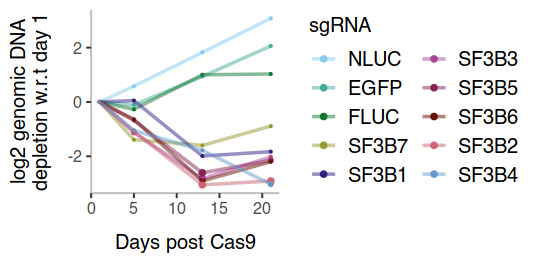

In [14]:
options(repr.plot.width = 4.5, repr.plot.height = 2.2)

subset_data <- mageck_gene %>%
  filter(str_detect(treatment, "grna")) %>%
  mutate(gene = if_else(gene == "PHF5A", "SF3B7", gene)) %>%
  filter(gene %in% c("NLUC", "FLUC", "EGFP", "SF3B5", "SF3B6") | str_detect(gene, "SF3B")) %>%
  mutate(day = as.numeric(str_extract(treatment, "(?<=day)\\d+"))) %>%
  select(day, gene, neg_p_value, lfc)
  
plot_data <- bind_rows(subset_data, subset_data %>% distinct(gene) %>% mutate(day = 1, neg_p_value = 1, lfc = 0)) %>% 
  mutate(sig = case_when(
            neg_p_value >= 0.05 ~ 1,
            neg_p_value >= 0.01 & neg_p_value < 0.05 ~ 2,
            neg_p_value >= 0.001 & neg_p_value < 0.01 ~ 3,
            neg_p_value < 0.001 ~ 4
          )) %>%
  group_by(gene) %>%
  mutate(ordering = lfc[day == 21]) %>%
  ungroup() %>%
  mutate(gene = fct_reorder(gene, -ordering)) %>%
  arrange(gene, day) %>%
  write_csv("../../../../source_data/figure_s3d.csv")

plot_data %>%
  ggplot(aes(x = day, y = lfc, color = gene, group = gene, size = as.factor(sig))) +
  geom_point() +
  scale_color_manual(values = cbPalette_12[c(1,8,3,4,5,6,9,7,2,10,11)]) +
  scale_size_manual(values = c(0.5, 1, 1.5, 2)) +
  geom_line(size = 1, alpha = 0.5) +
  labs(x = "Days post Cas9", y = "log2 genomic DNA\ndepletion w.r.t day 1", color = "sgRNA") +
  theme(legend.box = "horizontal") +
  guides(color = guide_legend(ncol = 2), size = "none")

ggsave("../figures/sf3b_fitness.pdf", width = 4.5, height = 2.2, units = "in")

## Plot gRNA depletion of eIF2,3,4 complex subunits

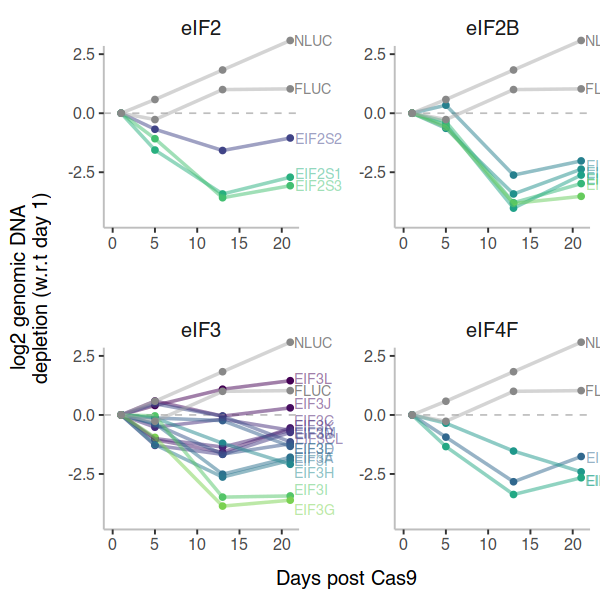

In [15]:
options(repr.plot.width = 5, repr.plot.height = 5)
set.seed(1010)

subset_data <- mageck_gene %>%
  filter(str_detect(treatment, "grna")) %>%
  mutate(gene_group = case_when(
    str_detect(gene, "FLUC|NLUC") ~ 'CONTROL',
    str_detect(gene, "EIF4(E$|A1|G1)") ~ 'eIF4F',
    str_detect(gene, "EIF2S") ~ 'eIF2',
    str_detect(gene, "EIF2B") ~ 'eIF2B',
    str_detect(gene, "EIF3") ~ 'eIF3'
  )) %>%
  filter(!is.na(gene_group)) %>%
  mutate(day = as.numeric(str_extract(treatment, "(?<=day)\\d+"))) %>%
  select(day, gene, neg_p_value, lfc, gene_group)

plot_data <- subset_data %>% 
  bind_rows(subset_data %>% distinct(gene, gene_group) %>% mutate(day = 1, neg_p_value = 1, lfc = 0)) %>%
  group_by(gene) %>%
  mutate(ordering = lfc[day == 21]) %>%
  ungroup() %>%
  mutate(gene = fct_reorder(gene, -ordering)) %>%
  arrange(gene, day) %>%
  write_csv("../../../../source_data/figure_s4e.csv")

control_data <- plot_data %>% 
  filter(gene_group == "CONTROL") %>%
  select(day, gene, lfc)

plot_data %>%
  filter(gene_group != "CONTROL") %>%
  ggplot(aes(x = day, y = lfc, group = gene, color = gene)) +
  facet_wrap(~gene_group, scales = "free", ncol = 2) +
  geom_point() +
  geom_text(aes(label = gene), data = . %>% filter(day == 21), size = 3, hjust = -0.1, alpha = 0.5, position = position_jitter(width = 0, height = 0.5)) +
  geom_hline(yintercept = 0, color = "grey", linetype = "dashed") +
  scale_size_manual(values = c(1, 2, 3, 4)) +
  scale_color_viridis_d(end = 0.8) +
  geom_line(size = 1, alpha = 0.5) +
  geom_line(data = control_data, size = 1, alpha = 0.5, color = "#AAAAAA") +
  geom_point(data = control_data, color = "#888888") +
  geom_text(aes(label = gene), data = control_data %>% filter(day == 21), size = 3, hjust = -0.1, color = "#888888") +
  labs(x = "Days post Cas9", y = "log2 genomic DNA\ndepletion (w.r.t day 1)") +
  theme(legend.position = "none", legend.box = "horizontal", panel.spacing = unit(0.5, "in")) +
  coord_cartesian(clip = "off", xlim = c(0, 21), ylim = c(-4.5, 2.5))

ggsave("../figures/eif_fitness_mrna.pdf", width = 5, height = 5, units = "in")